In [1]:
%pylab inline
from pygadgetreader import *
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)
from octopus import *

Populating the interactive namespace from numpy and matplotlib


# Computing the CM 

## Basic approach:

In [2]:
# Random points in a sphere:

r = random.random(1000) 
theta = random.random(1000) * 2 - 1
phi = random.random(1000) * 2 * np.pi

x1 = r**(1/3.0) * sin(arccos(theta)) * sin(phi)
y1 = r**(1/3.0) * sin(arccos(theta)) * cos(phi)
z1 = r**(1/3.0) * theta

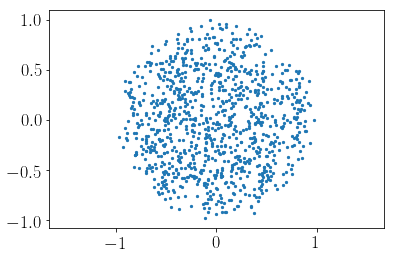

In [3]:
axis('equal')
scatter(x1, z1, s=5)

In [4]:
# CM coordinates:
xCM = sum(x1)/len(x1)
yCM = sum(y1)/len(y1)
zCM = sum(z1)/len(z1)

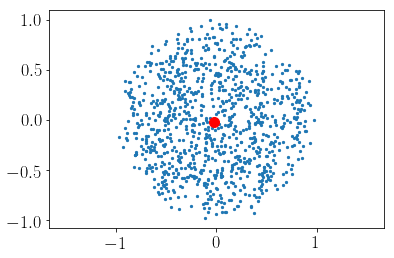

In [5]:
axis('equal')
scatter(x1, z1, s=5)
scatter(xCM, zCM, s=100, c='r')

## Iterative approach:


In [19]:
random.randint(0, 10, 10)

array([6, 5, 8, 4, 6, 9, 5, 0, 2, 1])

In [56]:
def velocities_r15(cm_pos, pos, vel, r_cut, bootstrapping=False):
    """
    Function to compute the COM velocity in a sphere of 15 kpc
    """
    # Compute the distance with respect to the COM
    print(cm_pos[0], cm_pos[1], cm_pos[2])
    R_cm = ((pos[:,0]-cm_pos[0])**2 + (pos[:,1]-cm_pos[1])**2 + (pos[:,2]-cm_pos[2])**2)**0.5
    # Select the particles inside 15 kpc
    index = np.where(R_cm <= r_cut)[0]
    print(len(index))
    N_r15_part = len(index)
    vx_r15 = vel[index,0]
    vy_r15 = vel[index,1]
    vz_r15 = vel[index,2]
    
    # Compute the velocities of the COM:
    if bootstrapping == False:
        velx_cm = sum(vx_r15)/N_r15_part
        vely_cm = sum(vy_r15)/N_r15_part
        velz_cm = sum(vz_r15)/N_r15_part
    elif bootstrapping == True:
        N_bs = 100000
        velx_cm = np.zeros(N_bs)
        vely_cm = np.zeros(N_bs)
        velz_cm = np.zeros(N_bs)
        
        print('here in bootstrapping')
        for i in range(N_bs):
            index_ran = random.randint(0, N_r15_part, N_r15_part)
            velx_cm[i] = sum(vx_r15[index_ran])/N_r15_part
            vely_cm[i] = sum(vy_r15[index_ran])/N_r15_part
            velz_cm[i] = sum(vz_r15[index_ran])/N_r15_part        

    return velx_cm, vely_cm, velz_cm, pos[index]



def CM(xyz, vxyz, r_cut, delta=0.025, bootstrapping=False):
    """
    Compute the center of mass coordinates and velocities of a halo
    using the Shrinking Sphere Method Power et al 2003.
    It iterates in radii until reach a convergence given by delta
    or 1% of the total number of particles.

    Parameters:
    -----------
    xyz: cartesian coordinates with shape (n,3)
    vxys: cartesian velocities with shape (n,3)
    delta(optional): Precision of the CM, D=0.025

    Returns:
    --------
    rcm, vcm: 2 arrays containing the coordinates and velocities of
    the center of mass with reference to a (0,0,0) point.

    """
    N_i = len(xyz)
    N = N_i

    xCM = 0.0
    yCM = 0.0
    zCM = 0.0

    xCM_new = sum(xyz[:,0])/N_i
    yCM_new = sum(xyz[:,1])/N_i
    zCM_new = sum(xyz[:,2])/N_i
    xyz_all = np.copy(xyz)
    while (((np.sqrt((xCM_new-xCM)**2 + (yCM_new-yCM)**2 + (zCM_new-zCM)**2) > delta) & (N>N_i*0.01)) | (N>1000)):
        xCM = xCM_new
        yCM = yCM_new
        zCM = zCM_new
        # Re-centering sphere
        xyz[:,0] = xyz[:,0]
        xyz[:,1] = xyz[:,1]
        xyz[:,2] = xyz[:,2]
        R = np.sqrt((xyz[:,0]-xCM_new)**2 + (xyz[:,1]-yCM_new)**2 + (xyz[:,2]-zCM_new)**2)
        Rmax = np.max(R)
        # Reducing Sphere by its 2.5%
        index = np.where(R<Rmax*0.975)[0]
        xyz = xyz[index]
        N = len(xyz)
        #Computing new CM coordinates and velocities
        xCM_new = np.sum(xyz[:,0])/N
        yCM_new = np.sum(xyz[:,1])/N
        zCM_new = np.sum(xyz[:,2])/N

    vxCM_new, vyCM_new, vzCM_new, pos_cuts = velocities_r15([xCM_new, yCM_new, zCM_new], xyz_all, vxyz, r_cut, bootstrapping)
    
    return np.array([xCM_new, yCM_new, zCM_new]), np.array([vxCM_new, vyCM_new, vzCM_new])

In [21]:
def CM_disk_potential(xyz, vxyz, Pdisk, V_radius):
    #V_radius = 5
    vx = vxyz[:,0]
    vy = vxyz[:,1]
    vz = vxyz[:,2]
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]

    min_pot = np.where(Pdisk==min(Pdisk))[0]
    x_min = x[min_pot]
    y_min = y[min_pot]
    z_min = z[min_pot]
    # This >2.0 corresponds to the radius in kpc of the particles that
    # I am taking into account to compute the CM
    avg_particles = np.where(np.sqrt((x-x_min)**2.0 + (y-y_min)**2.0 + (z-z_min)**2.0)<V_radius)[0]
    x_cm = sum(x[avg_particles])/len(avg_particles)
    y_cm = sum(y[avg_particles])/len(avg_particles)
    z_cm = sum(z[avg_particles])/len(avg_particles)
    vx_cm = sum(vx[avg_particles])/len(avg_particles)
    vy_cm = sum(vy[avg_particles])/len(avg_particles)
    vz_cm = sum(vz[avg_particles])/len(avg_particles)
    return np.array([x_cm, y_cm, z_cm]), np.array([vx_cm, vy_cm, vz_cm])



In [86]:
path = '../../../MW_anisotropy/code/test_snaps/'
snap_name = 'MWLMC5_40M_20new_b0_6_142'

In [9]:
def MW_LMC_particles(xyz, vxyz, pids, NMW_particles):
    sort_indexes = np.sort(pids)         
    N_cut = sort_indexes[NMW_particles]
    MW_ids = np.where(pids<=N_cut)[0]  
    LMC_ids = np.where(pids>N_cut)[0]  
    return xyz[MW_ids], vxyz[MW_ids], xyz[LMC_ids], vxyz[LMC_ids]  

In [11]:
NMW_particles=37500000
delta= 0.5
xyz = readsnap(path + snap_name , 'pos', 'dm')
vxyz = readsnap(path + snap_name ,'vel', 'dm')
pids = readsnap(path + snap_name ,'pid', 'dm')

MW_xyz_disk = readsnap(path + snap_name ,'pos', 'disk')
MW_vxyz_disk = readsnap(path + snap_name ,'vel', 'disk')
MW_pot_disk = readsnap(path + snap_name ,'pot', 'disk')

MW_xyz, MW_vxyz, LMC_xyz, LMC_vxyz = MW_LMC_particles(xyz, vxyz, pids, NMW_particles)
    
MW_rcm_pot, MW_vcm_pot = CM_disk_potential(MW_xyz_disk, MW_vxyz_disk, MW_pot_disk   )
MW_rcm, MW_vcm, pos_MW_cuts = CM(MW_xyz, MW_vxyz, delta)
LMC_rcm, LMC_vcm, pos_cut = CM(LMC_xyz, LMC_vxyz, delta)

#LMC_vx, LMC_vy, LMC_vz, R_shell = ss_velocities(LMC_rcm, LMC_xyz, LMC_vxyz, 0.5)


Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Positions
Returning DISK  Velocities
Returning DISK  Potential


TypeError: CM_disk_potential() missing 1 required positional argument: 'V_radius'

In [75]:
print(MW_rcm, MW_vcm)
print(LMC_rcm, LMC_vcm)

[ -1.07014455  47.52996992 -17.30965118] [ -0.10750176   1.58594452 -20.49398324]
[-27.02282104 -41.17894934  61.11838451] [ -23.41556964   18.35837046  137.29097855]


(-20, 20)

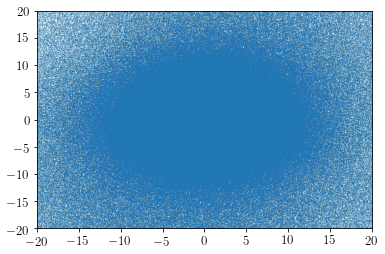

In [76]:
scatter(LMC_xyz[:,0]-(-27.022), LMC_xyz[:,1]-(-41.17), s=0.01, alpha=0.5)
xlim(-20, 20)
ylim(-20, 20)

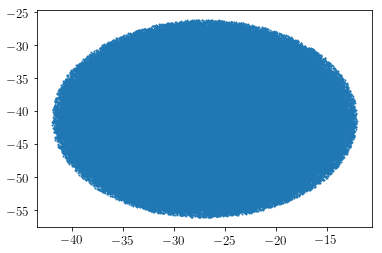

In [77]:
scatter(pos_cut[:,0], pos_cut[:,1], s=1)

In [23]:
def computing_MWLMC_CM(path, snap, i_n, i_f, Nhost, bootstrapping=False):
    N_snaps = (i_f - i_n) + 1

    x_mw = np.zeros(N_snaps)
    y_mw = np.zeros(N_snaps)
    z_mw = np.zeros(N_snaps)
    
    vx_mw = np.zeros(N_snaps)
    vy_mw = np.zeros(N_snaps)
    vz_mw = np.zeros(N_snaps)

    x_lmc = np.zeros(N_snaps)
    y_lmc = np.zeros(N_snaps)
    z_lmc = np.zeros(N_snaps)
    
    vx_lmc = np.zeros(N_snaps)
    vy_lmc = np.zeros(N_snaps)
    vz_lmc = np.zeros(N_snaps)
    
    Xd = np.zeros(N_snaps)
    Yd = np.zeros(N_snaps)
    Zd = np.zeros(N_snaps)

    VXd = np.zeros(N_snaps)
    VYd = np.zeros(N_snaps)
    VZd = np.zeros(N_snaps)

    time = np.zeros(N_snaps)

    for i in range(i_n, i_f + 1):
        #print 'snapshot' + str(i)
        time[i-i_n] = readheader(path + snap + "_{:0>3d}".format(i) ,'time')
        positions = readsnap(path + snap + "_{:0>3d}".format(i) ,'pos', 'dm')
        velocities = readsnap(path + snap + "_{:0>3d}".format(i), 'vel', 'dm')
        particles_ids = readsnap(path + snap + "_{:0>3d}".format(i), 'pid', 'dm')
        potential = readsnap(path + snap + "_{:0>3d}".format(i), 'pot', 'disk')
        positions_d = readsnap(path + snap + "_{:0>3d}".format(i),'pos', 'disk')
        v_d = readsnap(path + snap + "_{:0>3d}".format(i),'vel', 'disk')

        pos_mw, vel_mw, pos_lmc, vel_lmc = MW_LMC_particles(positions, velocities, particles_ids, Nhost)
       
        
        r_mw, v_mw = CM(pos_mw, vel_mw, 0.01, bootstrapping)
        x_mw[i-i_n], y_mw[i-i_n], z_mw[i-i_n] = r_mw[0], r_mw[1], r_mw[2] 

        vx_mw[i-i_n], vy_mw[i-i_n], vz_mw[i-i_n] = v_mw[0], v_mw[1], v_mw[2] 
        r_d, v_d =  CM_disk_potential(positions_d, v_d, potential)
        Xd[i-i_n], Yd[i-i_n], Zd[i-i_n] = r_d[0], r_d[1], r_d[2]
        VXd[i-i_n], VYd[i-i_n], VZd[i-i_n] = v_d[0], v_d[1], v_d[2]
        r_lmc, v_lmc = CM(pos_lmc, vel_lmc, 0.05) 
        x_lmc[i-i_n], y_lmc[i-i_n], z_lmc[i-i_n] = r_lmc[0], r_lmc[1], r_lmc[2]
        vx_lmc[i-i_n], vy_lmc[i-i_n], vz_lmc[i-i_n] = v_lmc[0], v_lmc[1], v_lmc[2]
        
    return x_mw, y_mw, z_mw, vx_mw, vy_mw, vz_mw, Xd, Yd, Zd, VXd, VYd, VZd, x_lmc, y_lmc, z_lmc, vx_lmc, vy_lmc, vz_lmc


In [24]:
def computing_MW_CM(path, snap, i_n, i_f, Nhost, v_radius, r_cut):
    N_snaps = (i_f - i_n) + 1

    x_mw = np.zeros(N_snaps)
    y_mw = np.zeros(N_snaps)
    z_mw = np.zeros(N_snaps)
    
    vx_mw = np.zeros(N_snaps)
    vy_mw = np.zeros(N_snaps)
    vz_mw = np.zeros(N_snaps)

    x_lmc = np.zeros(N_snaps)
    y_lmc = np.zeros(N_snaps)
    z_lmc = np.zeros(N_snaps)
    
    vx_lmc = np.zeros(N_snaps)
    vy_lmc = np.zeros(N_snaps)
    vz_lmc = np.zeros(N_snaps)
    
    Xd = np.zeros(N_snaps)
    Yd = np.zeros(N_snaps)
    Zd = np.zeros(N_snaps)

    VXd = np.zeros(N_snaps)
    VYd = np.zeros(N_snaps)
    VZd = np.zeros(N_snaps)

    time = np.zeros(N_snaps)

    for i in range(i_n, i_f + 1):
        #print 'snapshot' + str(i)
        time[i-i_n] = readheader(path + snap + "_{:0>3d}".format(i) ,'time')
        positions = readsnap(path + snap + "_{:0>3d}".format(i) ,'pos', 'dm')
        velocities = readsnap(path + snap + "_{:0>3d}".format(i), 'vel', 'dm')
        particles_ids = readsnap(path + snap + "_{:0>3d}".format(i), 'pid', 'dm')
        potential = readsnap(path + snap + "_{:0>3d}".format(i), 'pot', 'disk')
        positions_d = readsnap(path + snap + "_{:0>3d}".format(i),'pos', 'disk')
        v_d = readsnap(path + snap + "_{:0>3d}".format(i),'vel', 'disk')

        pos_mw, vel_mw, pos_lmc, vel_lmc = MW_LMC_particles(positions, velocities, particles_ids, Nhost)
      
        
        r_mw, v_mw = CM(pos_mw, vel_mw, r_cut, 0.01)
        x_mw[i-i_n], y_mw[i-i_n], z_mw[i-i_n] = r_mw[0], r_mw[1], r_mw[2] 

        vx_mw[i-i_n], vy_mw[i-i_n], vz_mw[i-i_n] = v_mw[0], v_mw[1], v_mw[2] 
        r_d, v_d =  CM_disk_potential(positions_d, v_d, potential, v_radius )
        Xd[i-i_n], Yd[i-i_n], Zd[i-i_n] = r_d[0], r_d[1], r_d[2]
        VXd[i-i_n], VYd[i-i_n], VZd[i-i_n] = v_d[0], v_d[1], v_d[2]

        
    return x_mw, y_mw, z_mw, vx_mw, vy_mw, vz_mw, Xd, Yd, Zd, VXd, VYd, VZd


In [34]:
def computing_LMC_CM(path, snap, N_snap, Nhost,  r_cut, bootstrapping=False):

    #print 'snapshot' + str(i)
    positions = readsnap(path + snap + "_{:0>3d}".format(N_snap) ,'pos', 'dm')
    velocities = readsnap(path + snap + "_{:0>3d}".format(N_snap), 'vel', 'dm')
    particles_ids = readsnap(path + snap + "_{:0>3d}".format(N_snap), 'pid', 'dm')

    
    pos_mw, vel_mw, pos_lmc, vel_lmc = MW_LMC_particles(positions, velocities, particles_ids, Nhost)
    
    r_lmc, v_lmc = CM(pos_lmc, vel_lmc, r_cut, 0.01, bootstrapping)
    vx_lmc, vy_lmc, vz_lmc = v_lmc[0], v_lmc[1], v_lmc[2] 
    return [vx_lmc, vy_lmc, vz_lmc]

In [16]:
path = '../../../MW_anisotropy/code/test_snaps/lr/'
snap = 'MWLMC5_test_b0_lr_ics42'
i_n = 0
i_f = 140
Nhost = 1000000
r_cut = np.linspace(1, 50, 10)
Nsnap = [0, 25, 50, 100]
vxlmc = np.zeros((4,50))
vylmc = np.zeros((4,50))
vzlmc = np.zeros((4,50))

for j in range(4):
    for i in range(len(r_cut)):
        vxlmc[j,i], vylmc[j,i], vzlmc[j,i] = computing_LMC_CM(path, snap, Nsnap[j], Nhost, r_cut[i])


Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
1058
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
26522
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
62006
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
96323
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
127335
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
153932
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
176734
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328

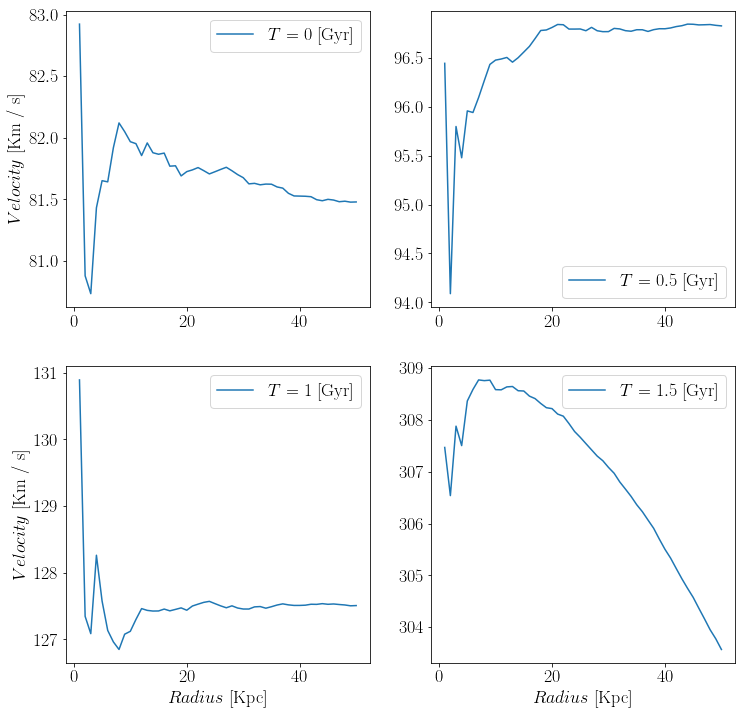

In [39]:
figure(figsize=(12, 12))
subplot(2, 2, 1)
plot(r_cut, np.sqrt(vxlmc[0]**2 + vylmc[0]**2 + vzlmc[0]**2), label='$T = 0$ [Gyr]')
ylabel('$Velocity$ [Km / s]')
legend()

subplot(2, 2, 2)
plot(r_cut, np.sqrt(vxlmc[1]**2 + vylmc[1]**2 + vzlmc[1]**2), label='$T = 0.5$ [Gyr]')
legend()

subplot(2, 2, 3)
xlabel('$Radius$ [Kpc]')
plot(r_cut, np.sqrt(vxlmc[2]**2 + vylmc[2]**2 + vzlmc[2]**2), label='$T = 1$ [Gyr]')
ylabel('$Velocity$ [Km / s]')
legend()

subplot(2, 2, 4)
plot(r_cut, np.sqrt(vxlmc[3]**2 + vylmc[3]**2 + vzlmc[3]**2), label='$T = 1.5$ [Gyr]')
legend()
xlabel('$Radius$ [Kpc]')
#savefig('Vcom_r.png', dpi=150, bbox_inches='tight')

In [57]:
vx_dist, vy_dist, vz_dist = computing_LMC_CM(path, snap, Nsnap[0], Nhost, 15, bootstrapping=True)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
82160
here in bootstrapping


In [75]:
vx_dist_f, vy_dist_f, vz_dist_f = computing_LMC_CM(path, snap, 113, Nhost, 15, bootstrapping=True)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
-5.16235832254 -15.0631861237 -18.5805942358
78142
here in bootstrapping


In [53]:
vx, vy, vz = computing_LMC_CM(path, snap, Nsnap[0], Nhost, 15, bootstrapping=False)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
12.0033233328 241.798179768 129.83501933
82160


In [78]:
vx_f, vy_f, vz_f = computing_LMC_CM(path, snap, 113, Nhost, 15, bootstrapping=False)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
-5.16235832254 -15.0631861237 -18.5805942358
78142


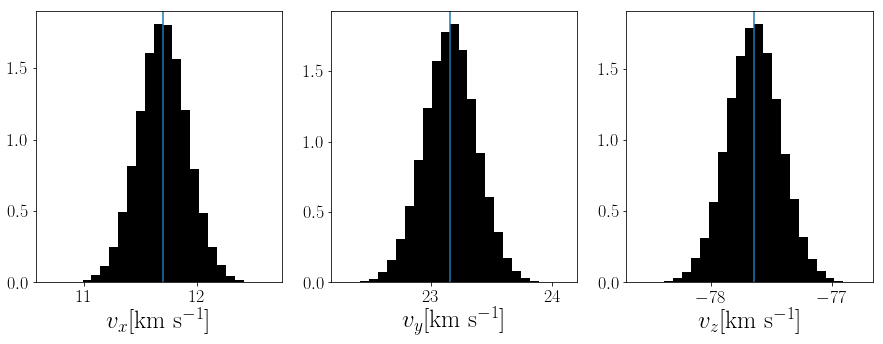

In [82]:
figure(figsize=(15, 5))
subplot(1, 3, 1)
hist(vx_dist, bins=25, normed=True, color='k')
xlabel('$v_x$[km s^{-1}]', fontsize=25)
axvline(vx)
subplot(1, 3, 2)
hist(vy_dist, bins=25, normed=True, color='k')
xlabel('$v_y$[km s^{-1}]', fontsize=25)
axvline(vy)

subplot(1, 3, 3)
hist(vz_dist, bins=25, normed=True, color='k')
xlabel('$v_z$[km s^{-1}]', fontsize=25)
axvline(vz)
savefig('Velocities_dist_lmc_r15_snap0.png', bbox_inches='tight')


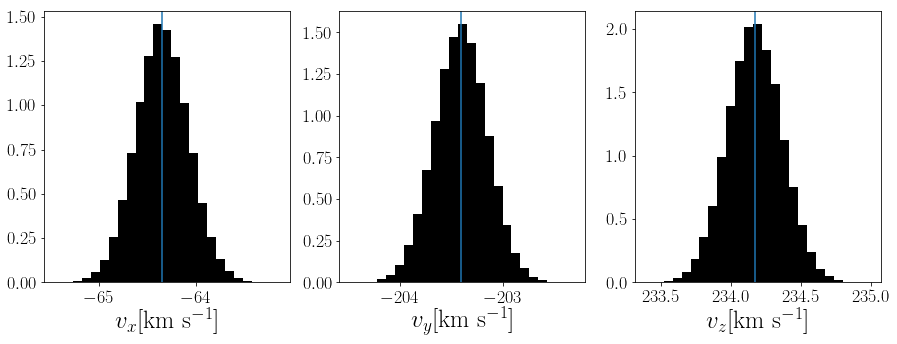

In [81]:
figure(figsize=(15, 5))
subplot(1, 3, 1)
hist(vx_dist_f, bins=25, normed=True, color='k')
xlabel('$v_x$[km s^{-1}]', fontsize=25)
axvline(vx_f)
subplot(1, 3, 2)
hist(vy_dist_f, bins=25, normed=True, color='k')
xlabel('$v_y$[km s^{-1}]', fontsize=25)
axvline(vy_f)

subplot(1, 3, 3)
hist(vz_dist_f, bins=25, normed=True, color='k')
xlabel('$v_z$[km s^{-1}]', fontsize=25)
axvline(vz_f)
savefig('Velocities_dist_lmc_r15_snap113.png', bbox_inches='tight')


In [84]:
path = '../../../MW_anisotropy/code/test_snaps/lr/'
snap = 'MWLMC5_test_b0_lr_ics42'
i_n = 0
i_f = 140
Nhost = 1000000
v_radius = [1, 2, 5, 10, 15]
r_cut = [1, 2, 5, 10, 15]

xmw = np.zeros((5, 141))
ymw = np.zeros((5, 141))
zmw = np.zeros((5, 141))

vxmw = np.zeros((5, 141))
vymw = np.zeros((5, 141))
vzmw = np.zeros((5, 141))

xd = np.zeros((5, 141))
yd = np.zeros((5, 141))
zd = np.zeros((5, 141))

vxd = np.zeros((5, 141))
vyd = np.zeros((5, 141))
vzd = np.zeros((5, 141))
for i in ran
for j in range(len(v_radius)):
        xmw[i], ymw[i], zmw[i], vxmw[i], vymw[i], vzmw[i], xd[j], yd[j], zd[j], vxd[j], vyd[j], vzd[j] = computing_MW_CM(path, snap, i_n, i_f, 
                                                                                                                 Nhost, v_radius[j], r_cut[i])


IndexError: list index out of range

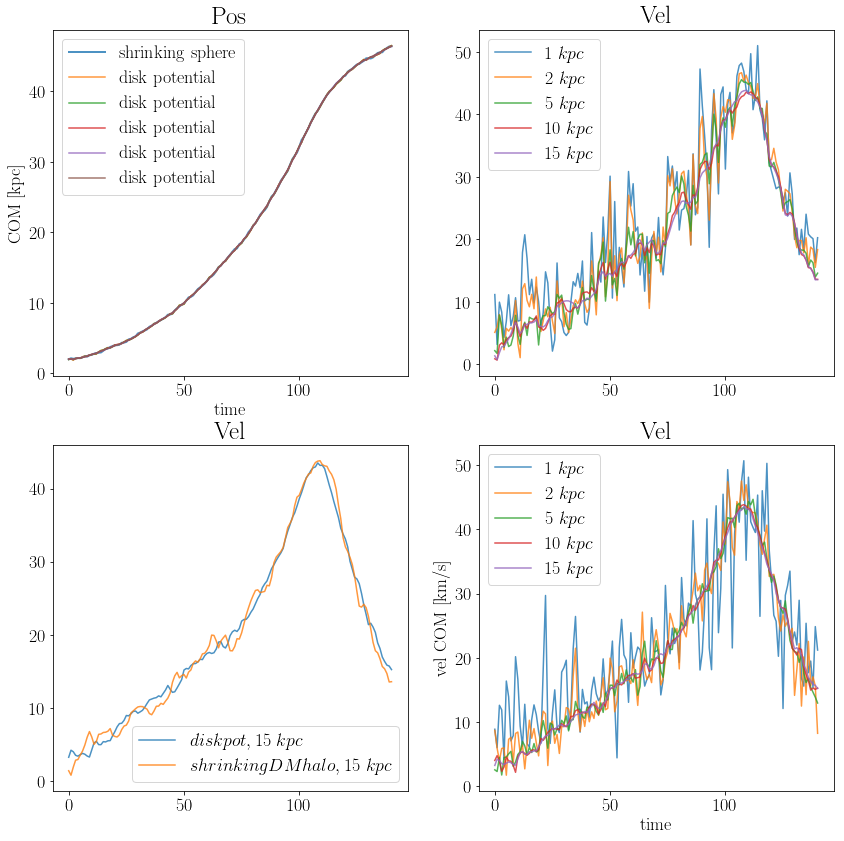

In [171]:
time = np.linspace(0, 2, 100)
figure(figsize=(14,14))
subplot(2, 2, 1)
title('Pos', fontsize=25)
plt.plot(np.sqrt(xmw[0]**2.0 + ymw[0]**2.0 + zmw[0]**2.0), lw=2, alpha=0.8, label='shrinking sphere')
plt.plot(np.sqrt(xd[0]**2.0 + yd[0]**2.0 + zd[0]**2.0), alpha=0.8, label='disk potential')
plt.plot(np.sqrt(xd[1]**2.0 + yd[1]**2.0 + zd[1]**2.0), alpha=0.8, label='disk potential')
plt.plot(np.sqrt(xd[2]**2.0 + yd[2]**2.0 + zd[2]**2.0), alpha=0.8, label='disk potential')
plt.plot(np.sqrt(xd[3]**2.0 + yd[3]**2.0 + zd[3]**2.0), alpha=0.8, label='disk potential')
plt.plot(np.sqrt(xd[4]**2.0 + yd[4]**2.0 + zd[4]**2.0), alpha=0.8, label='disk potential')
xlabel('time')
ylabel('COM [kpc]')
legend()

subplot(2, 2, 2)
title('Vel', fontsize=25)
#plt.plot(np.sqrt(vxmw[0]**2.0 + vymw[0]**2.0 + vzmw[0]**2.0), lw=2, alpha=0.8)#
plt.plot(np.sqrt(vxd[0]**2.0 + vyd[0]**2.0 + vzd[0]**2.0),  alpha=0.8, label='$1\ kpc$')
plt.plot(np.sqrt(vxd[1]**2.0 + vyd[1]**2.0 + vzd[1]**2.0),  alpha=0.8, label='$2\ kpc$')
plt.plot(np.sqrt(vxd[2]**2.0 + vyd[2]**2.0 + vzd[2]**2.0),  alpha=0.8, label='$5\ kpc$')
plt.plot(np.sqrt(vxd[3]**2.0 + vyd[3]**2.0 + vzd[3]**2.0),  alpha=0.8, label='$10\ kpc$')
plt.plot(np.sqrt(vxd[4]**2.0 + vyd[4]**2.0 + vzd[4]**2.0),  alpha=0.8, label='$15\ kpc$')
legend()

subplot(2, 2, 3)
title('Vel', fontsize=25)
plt.plot(np.sqrt(vxmw[4]**2.0 + vymw[4]**2.0 + vzmw[4]**2.0), label='$disk pot, 15\ kpc$', alpha=0.8)#
plt.plot(np.sqrt(vxd[4]**2.0 + vyd[4]**2.0 + vzd[4]**2.0),  alpha=0.8, label='$shrinking DM halo, 15\ kpc$')
legend()

subplot(2, 2, 4)
title('Vel', fontsize=25)
plt.plot(np.sqrt(vxmw[0]**2.0 + vymw[0]**2.0 + vzmw[0]**2.0), label='$1\ kpc$', alpha=0.8)#
plt.plot(np.sqrt(vxmw[1]**2.0 + vymw[1]**2.0 + vzmw[1]**2.0), label='$2\ kpc$', alpha=0.8)#
plt.plot(np.sqrt(vxmw[2]**2.0 + vymw[2]**2.0 + vzmw[2]**2.0), label='$5\ kpc$', alpha=0.8)#
plt.plot(np.sqrt(vxmw[3]**2.0 + vymw[3]**2.0 + vzmw[3]**2.0), label='$10\ kpc$', alpha=0.8)#
plt.plot(np.sqrt(vxmw[4]**2.0 + vymw[4]**2.0 + vzmw[4]**2.0), label='$15\ kpc$', alpha=0.8)#

legend()

xlabel('time')
ylabel('vel COM [km/s]')
#ylim(0, 25)
savefig('v_COM_diagnostic.png', dpi=300, bbox_inches='tight')

# Testing the code in a simulation snapshot:

In [139]:
orbit = computing_MW_CM('../../../MW_anisotropy/code/test_snaps/lr/', 'MWLMC5_test_b0_lr_ics42', 0, 140, 1000000)
Xcm, Ycm, Zcm, VxCm, VyCm, VzCm, Xd, Yd, Zd, Vxd, Vyd, Vzd, xlmc, ylmc, zlmc, vxlmc, vylmc, vzlmc = orbit

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.783389772405 1.53678301085 0.945533112047
2545
12.0033233328 241.798179768 129.83501933
3684
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.818600889112 1.65776262127 1.02249883433
2555
12.2548067562 242.302505192 128.311591381
3510
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.716422774306 1.6726344364 0.917193975912
2557
12.424261013 242.621257878 126.760914522
3100
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.722358734502 1.62829046211 1.09019698788
2541
12.8796919207 243.11

-2.09763946379 4.75084967849 2.8632790283
2506
18.5588844292 240.246081804 73.0772171254
3410
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.05929225653 4.85757150153 2.95257487312
2521
18.7266744498 239.577021494 70.9781537871
3480
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-1.97764049412 5.06232482281 3.01267115013
2475
18.8786683566 238.92305847 68.9326381781
3390
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-1.92021753154 5.47800544327 3.11581523557
2469
18.9253278821 238.255327073 67.0307682966
3351
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Retur

21.3409783454 197.855112163 5.81802811365
3287
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.80492832419 13.4334345611 6.21365595611
2466
21.313391947 195.624458461 3.51942647609
3192
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.83660869618 13.6034658315 6.33275884495
2561
21.1504590145 193.352262487 1.32456145203
3237
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-3.06555411726 14.0229427613 6.36705884807
2496
21.1046229859 191.129232754 -0.760659700914
3349
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-3.04628376788 14.24735

13.1607584147 82.6813063063 -52.6931658221
3218
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.77384024293 29.4068324752 7.10342143102
2495
12.4737532383 77.0594640544 -53.3260119819
3163
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.67342507925 29.9207526068 7.06594763774
2430
11.9078886218 71.4780208333 -53.7175280449
3110
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.63729537492 30.4032397713 6.97497583763
2522
11.0515857134 65.5567767034 -53.8130523181
3129
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.24515220767 31.35

-0.259029015042 43.4218001072 -8.99790004572
2477
-20.2531410256 -41.5148397436 50.2842548077
2405
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.274044996296 43.6780016034 -9.51961475887
2464
-20.9715144832 -41.6786043856 54.2015531156
2376
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.318464181607 43.567401423 -10.0265679852
2415
-21.4310914972 -41.6912895855 57.9014908921
2412
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.386166259263 43.4579203141 -10.3398799562
2423
-22.0122672033 -41.6360440341 61.5037365846
2389
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK

In [131]:
orbit10 = computing_MW_CM('../../../MW_anisotropy/code/test_snaps/lr/', 'MWLMC5_test_b0_lr_ics42', 0, 140, 1000000)
Xcm10, Ycm10, Zcm10, VxCm10, VyCm10, VzCm10, Xd10, Yd10, Zd10, Vxd10, Vyd10, Vzd10, xlmc10, ylmc10, zlmc10, vxlmc10, vylmc10, vzlmc10 = orbit10

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.783389772405 1.53678301085 0.945533112047
49740
12.0033233328 241.798179768 129.83501933
49627
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.818600889112 1.65776262127 1.02249883433
49838
12.2548067562 242.302505192 128.311591381
49632
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.716422774306 1.6726344364 0.917193975912
49962
12.424261013 242.621257878 126.760914522
49607
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.722358734502 1.62829046211 1.09019698788
49687
12.8796919207

18.4739720601 240.811197917 75.0987700803
49424
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.09763946379 4.75084967849 2.8632790283
49604
18.5588844292 240.246081804 73.0772171254
49435
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.05929225653 4.85757150153 2.95257487312
49492
18.7266744498 239.577021494 70.9781537871
49556
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-1.97764049412 5.06232482281 3.01267115013
49590
18.8786683566 238.92305847 68.9326381781
49514
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-1.92021753154 5.47

-2.96850977345 12.3612557146 5.94302178576
49743
21.4204599809 200.047496811 8.06168038504
49232
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.6580779053 12.9262095669 6.08810831076
49788
21.3409783454 197.855112163 5.81802811365
49214
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.80492832419 13.4334345611 6.21365595611
49587
21.313391947 195.624458461 3.51942647609
49135
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.83660869618 13.6034658315 6.33275884495
49607
21.1504590145 193.352262487 1.32456145203
49216
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positio

-2.80349974837 27.6136047738 7.39649685663
49786
13.8400407124 88.1425884372 -51.9824115628
48768
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.56910023315 28.5420893325 7.37627771188
49763
13.1607584147 82.6813063063 -52.6931658221
48875
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.77384024293 29.4068324752 7.10342143102
49570
12.4737532383 77.0594640544 -53.3260119819
48894
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.67342507925 29.9207526068 7.06594763774
49572
11.9078886218 71.4780208333 -53.7175280449
48868
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  P

-0.161423074856 43.2673289609 -8.69399635095
50078
-19.6206597222 -41.2346370545 46.3181177935
33613
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.259029015042 43.4218001072 -8.99790004572
50021
-20.2531410256 -41.5148397436 50.2842548077
32932
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.274044996296 43.6780016034 -9.51961475887
49846
-20.9715144832 -41.6786043856 54.2015531156
32459
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.318464181607 43.567401423 -10.0265679852
49785
-21.4310914972 -41.6912895855 57.9014908921
32051
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Return

In [134]:
orbit2 = computing_MW_CM('../../../MW_anisotropy/code/test_snaps/lr/', 'MWLMC5_test_b0_lr_ics42', 0, 140, 1000000)
Xcm2, Ycm2, Zcm2, VxCm2, VyCm2, VzCm2, Xd2, Yd2, Zd2, Vxd2, Vyd2, Vzd2, xlmc2, ylmc2, zlmc2, vxlmc2, vylmc2, vzlmc2 = orbit2

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.783389772405 1.53678301085 0.945533112047
2545
12.0033233328 241.798179768 129.83501933
3684
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.818600889112 1.65776262127 1.02249883433
2555
12.2548067562 242.302505192 128.311591381
3510
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.716422774306 1.6726344364 0.917193975912
2557
12.424261013 242.621257878 126.760914522
3100
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.722358734502 1.62829046211 1.09019698788
2541
12.8796919207 243.11

-2.09763946379 4.75084967849 2.8632790283
2506
18.5588844292 240.246081804 73.0772171254
3410
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.05929225653 4.85757150153 2.95257487312
2521
18.7266744498 239.577021494 70.9781537871
3480
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-1.97764049412 5.06232482281 3.01267115013
2475
18.8786683566 238.92305847 68.9326381781
3390
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-1.92021753154 5.47800544327 3.11581523557
2469
18.9253278821 238.255327073 67.0307682966
3351
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Retur

21.3409783454 197.855112163 5.81802811365
3287
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.80492832419 13.4334345611 6.21365595611
2466
21.313391947 195.624458461 3.51942647609
3192
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.83660869618 13.6034658315 6.33275884495
2561
21.1504590145 193.352262487 1.32456145203
3237
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-3.06555411726 14.0229427613 6.36705884807
2496
21.1046229859 191.129232754 -0.760659700914
3349
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-3.04628376788 14.24735

13.1607584147 82.6813063063 -52.6931658221
3218
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.77384024293 29.4068324752 7.10342143102
2495
12.4737532383 77.0594640544 -53.3260119819
3163
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.67342507925 29.9207526068 7.06594763774
2430
11.9078886218 71.4780208333 -53.7175280449
3110
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.63729537492 30.4032397713 6.97497583763
2522
11.0515857134 65.5567767034 -53.8130523181
3129
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-2.24515220767 31.35

-0.259029015042 43.4218001072 -8.99790004572
2477
-20.2531410256 -41.5148397436 50.2842548077
2405
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.274044996296 43.6780016034 -9.51961475887
2464
-20.9715144832 -41.6786043856 54.2015531156
2376
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.318464181607 43.567401423 -10.0265679852
2415
-21.4310914972 -41.6912895855 57.9014908921
2412
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
-0.386166259263 43.4579203141 -10.3398799562
2423
-22.0122672033 -41.6360440341 61.5037365846
2389
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK

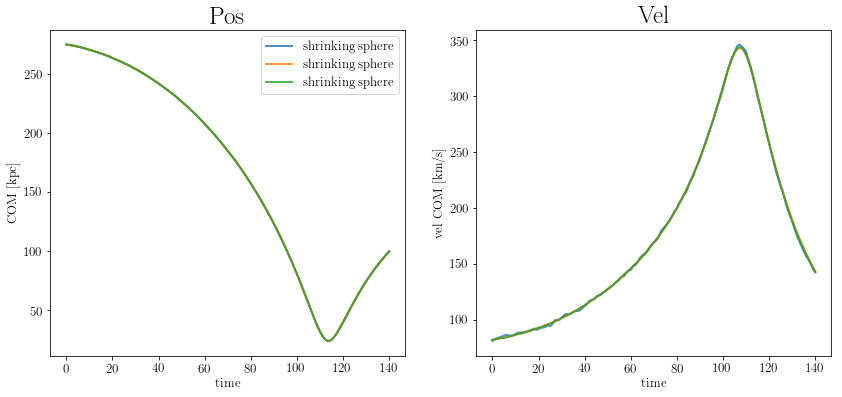

In [137]:
time = np.linspace(0, 2, 100)
figure(figsize=(14,6))
subplot(1, 2, 1)
title('Pos', fontsize=25)
plt.plot(np.sqrt(xlmc2**2.0 + ylmc2**2.0 + zlmc2**2.0), lw=2, alpha=0.8, label='shrinking sphere')

plt.plot(np.sqrt(xlmc**2.0 + ylmc**2.0 + zlmc**2.0), lw=2, alpha=0.8, label='shrinking sphere')
plt.plot(np.sqrt(xlmc10**2.0 + ylmc10**2.0 + zlmc10**2.0), lw=2, alpha=0.8, label='shrinking sphere')

xlabel('time')
ylabel('COM [kpc]')
legend()

subplot(1, 2, 2)
title('Vel', fontsize=25)
plt.plot(np.sqrt(vxlmc2**2.0 + vylmc2**2.0 + vzlmc2**2.0), lw=2, alpha=0.8)#
plt.plot(np.sqrt(vxlmc**2.0 + vylmc**2.0 + vzlmc**2.0), lw=2, alpha=0.8)#
plt.plot(np.sqrt(vxlmc10**2.0 + vylmc10**2.0 + vzlmc10**2.0), lw=2, alpha=0.8)#
xlabel('time')
ylabel('vel COM [km/s]')
#ylim(250, 350)

# Comparing the same snapshot with different resolution, Comparisson with the potential method

In [85]:
Xcm, Ycm, Zcm, VxCm, VyCm, VzCm, Xd, Yd, Zd, Vxd, Vyd, Vzd = computing_MW_CM('../../data/LMCMW/MW1LMC4/a1/', 'MW1LMC4a1H6', 0, 10, 100000)


TypeError: computing_MW_CM() missing 2 required positional arguments: 'v_radius' and 'r_cut'

In [30]:
pothalo1, poshalo1, velhalo1, idhalo1, potdisk1, posdisk1, veldisk1 = loading_data("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000")
pothalo2, poshalo2, velhalo2, idhalo2, potdisk2, posdisk2, veldisk2 = loading_data("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000")
pothalo3, poshalo3, velhalo3, idhalo3, potdisk3, posdisk3, veldisk3 = loading_data("MW1LMC4_a1H6UHR_000")

Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities


# Poisson Noise

$\dfrac{\sigma_x}{\sqrt{N}}$

following http://adsabs.harvard.edu/abs/2013ApJ...762..109B

In [154]:
def poissonN(x, y, z):
    #R = np.sqrt(x**2 + y**2 + z**2)
    pn = np.zeros(700)
    pn[0] = np.std(x)/ np.sqrt(len(x))
    Xmax = np.zeros(700)
    Xmax[0] = max(abs(x))
    i=0
    while len(x)>3:
        i+=1
        low_s = np.where(abs(x) <= 0.8*max(abs(x)))[0]
        #x = x[low_s]
        x = x[low_s]
        Xmax[i] = max(x)
        pn[i] = np.std(x) / (len(x)**(3.0/2.0)) # is this ok??
        
    index = np.where(pn!=0)[0]
    pn = pn[index]
    min_pn = np.where(pn == min(pn))
    return pn[index], Xmax[index]


In [155]:
PN1, Renclosed1 = poissonN(Xmwhalo1, Ymwhalo1, Zmwhalo1)
PN2, Renclosed2 = poissonN(Xmwhalo2, Ymwhalo2, Zmwhalo2)
PN3, Renclosed3 = poissonN(Xmwhalo3, Ymwhalo3, Zmwhalo3)

In [94]:
print type(Zmwhalo2)

<type 'numpy.ndarray'>


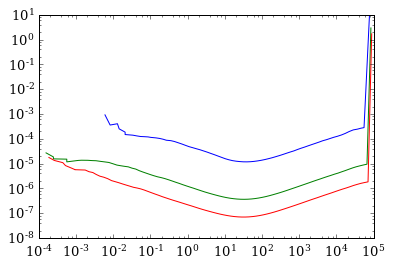

In [153]:
plot(Renclosed1, PN1)
plot(Renclosed2, PN2)
plot(Renclosed3, PN3)
xscale('log')
yscale('log')

In [135]:
print len(PN1)

70
